_Since we announced [our collaboration with the World Bank and more partners to create the Open Traffic platform](https://mapzen.com/blog/announcing-open-traffic/), we’ve been busy. We’ve shared [two](https://mapzen.com/blog/open-traffic-osmlr-technical-preview/) [technical](https://mapzen.com/blog/osmlr-2nd-technical-preview/) previews of the OSMLR linear referencing system. Now we’re ready to share more about how we’re using [Mapzen Map Matching](https://mapzen.com/blog/map-matching/) to “snap” GPS-derived locations to OSMLR segments, and how we’re using a data-driven approach to evaluate and improve the algorithms._

# A "data-driven" approach to improving map-matching, Part I

Mapzen has been testing and matching GPS measurements from some of Open Traffic’s partners since development began, but one burning question remained: were our matches any good? Map-matching real-time GPS traces is one thing, but without on-the-ground knowledge about where the traces actually came from, it was impossible to to determine how close to — or far from — the truth our predictions were.

Our in-house solution was to use Mapzen's very own [Turn-By-Turn](https://mapzen.com/products/turn-by-turn/) routing API to simulate fake GPS data, send the synthetic data through the [Mapzen Map Matching](https://mapzen.com/blog/map-matching/) service, and compare the results to the original routes used to simulate the fake traces. We have documented this process below:

## 0. Setup test environment

In [1]:
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import cm, colors, patheffects
import numpy as np
import os
import glob
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
%matplotlib inline

#### User vars

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')

## 1. Generate Routes

The first step in route generation is picking a test region, which for us was San Francisco. Routes are defined as a set of start and stop coordinates, which we obtain by randomly sampling venues from Mapzen’s [Who’s on First](https://whosonfirst.mapzen.com/) gazetteer for the specified city. Additionally, we want to limit our route distances to be between ½ km and 1 km because this is the localized scale at which map matching actually takes place.

In this example, we specify 200 fake routes:

In [3]:
cityName = 'San Francisco'
minRouteLen = 1     # specified in km
maxRouteLen = 5     # specified in km
numRoutes = 200

#### a) Get random start and end coordinates

In [29]:
# Using Mapzen Venues (requires good Who's on First coverage)
routeList = val.get_routes_by_length(cityName, minRouteLen, maxRouteLen, numRoutes, apiKey=mapzenKey)

## Using Google Maps POIs (better for non-Western capitals):
# routeList = val.get_POI_routes_by_length(cityName, minRouteLen, maxRouteLen, numRoutes, gmapsKey)

A sample route:

In [19]:
myRoute = routeList[2]
myRoute

({u'Cabovida Dvelopments A Cal Ltd': {'lat': 37.775456, 'lon': -122.406369}},
 {u'Palomar Group': {'lat': 37.788245, 'lon': -122.409508}})

#### b) Get the route shapes and attributes

For each route, we then pass the start and end coordinates to the Turn-By-Turn API to obtain the coordinates of the road segments along the route:

In [17]:
shape, routeUrl = val.get_route_shape(myRoute)

The Turn-By-Turn API returns the shape of the route as an [encoded polyline](https://developers.google.com/maps/documentation/utilities/polylinealgorithm):

In [18]:
shape

u'mes`gAv}anhFtUr[q{@vkAgOnS{EaHqRwWuY{`@sLePoMcQiMqQqMcQiCwD}TsZ}Yz`@cV`\\mYj`@{Zxa@}U`\\}Yj`@}Yj`@cUd[wTbZmDlKO\\Ol@}D|IsAzAwC|@sp@nHcy@|J}x@lJmy@|Jey@|J}OhBuThCqRxBaLqeBqCuc@'

The route shape then gets passed to the map matching service in order to obtain the coordinates and attributes of the road segments (i.e. edges) that lie along the original route:

In [24]:
edges, matchedPts, shapeCoords, _ = val.get_trace_attrs(shape)

We can inspect the attributes returned for our example route:

In [28]:
val.format_edge_df(edges).head()

,id,begin_shape_index,end_shape_index,length,speed,density,oneSecCoords,segment_id,num_segments,starts_segment,ends_segment,begin_percent,end_percent,begin_resampled_shape_index,end_resampled_shape_index
0,3738534172576,0,1,0.057,40,15,"[[-122.40638, 37.775463], [-122.406469252, 37....",497780021152,1,True,True,0.0,1.0,None,None
1,962716097074,1,2,0.153,35,15,"[[-122.406916267, 37.7751617604], [-122.406994...",39633672754,1,True,True,0.0,1.0,None,None
2,931778910770,2,3,0.041,35,15,"[[-122.408144091, 37.7761309014], [-122.408222...",39633672754,1,False,False,0.0,1.0,None,None
3,3780477212576,3,4,0.018,40,15,"[[-122.408302818, 37.7763981724], [-122.408249...",None,0,None,None,NaN,NaN,None,None
4,4122363320224,4,5,0.049,40,15,"[[-122.408159625, 37.7765096426], [-122.408070...",None,0,None,None,NaN,NaN,None,None


## 3. Iterate Through Routes, Generate Fake GPS, and Score the Matches

#### a) Define the noise levels and sample rates for synthetic GPS

Now that we have a set of "ground-truthed" routes, meaning route coordinates and their associated road segments, we want to simulate what the GPS data recorded along these routes might look like. This involves two main steps:
1. resampling the coordinates to reflect real-world GPS sample frequencies
2. perturbing the coordinates to simulate the effect of GPS "noise"

To resample the coordinates, we use the known speeds along each road segment to retain points along the route after every $n$ seconds.

To simulate GPS noise, we randomly sample from a normal distribution with standard deviation equal to a specified level of noise (in meters). We then apply this vector of noise to a given coordinate pair, and use a rolling average to smooth out the change in noise between subsequent "measurements", recreating the phenomenon of GPS "drift".

![my gif](make-some-noise.gif)

<center><i>A route (blue line) is resampled at 5 second intervals (blue dots). The resampled points are then perturbed with noise sampled from a gaussian distribution with mean 0 and standard deviation of 60. The resulting “measurements” (red dots) represent a simulated GPS trace.</i></center>


Since we are interested in assessing the performance of map-matching under a variety of different conditions, we define a range of realistic sample rates and noise levels:

In [21]:
sampleRates = [1, 5, 10, 20, 30]    # specified in seconds
noiseLevels = np.linspace(0, 100, 21)    # specified in meters

#### b) Defining a validation metric

In order to validate our matched routes, we need an effective method of scoring. Should Type I error (false negatives) carry as much weight as Type II (false negatives)? Should a longer mismatched segment carry a greater penalty than one that is shorter?

We adopt the scoring mechanism proposed by [Newton and Krumm (2009)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/map-matching-ACM-GIS-camera-ready.pdf), upon whose map-matching algorithm the Meili service is based:

<img src="krumm_newson_dist.png" alt="Drawing" style="width: 400px;" align="center"/>
<center><i>From Newton and Krumm (2009)</i></center>

In the above schematic, $\text{d}_+$ refers to a false positive or Type I error, while $\text{d}_-$ represents a false negative, or Type II error. The final reported error is a combination of both types of mismatches, weighted by their respective lengths.

#### c) Generate the scores

Behind the scenes, the `get_route_metrics()` function will perform the following actions:
1. resample points along a given route at each of the specified sample rates
2. apply gaussian noise to each of the resample points at each of the specified noise levels
3. pass these synthetic measurements to the Open Traffic Reporter and record the matched routes that are returned
4. compare the segments on the "matched" route to the segments of the original route and score the results

In [22]:
matchDf, _, _ = val.get_route_metrics(routeList, sampleRates, noiseLevels, saveResults=False)

Iterating through each our 200 routes at 5 sample rates and 21 levels of noise, we simulate 21,000 distinct GPS traces. We then pass each of these simulated traces through to the map-matching service, and compare the resulting routes against the ground-truthed, pre-perturbation route segments.

![my gif](mm-noise.gif)

<center><i>The same route is perturbed with varying levels of gaussian noise (red dots) with standard deviations ranging from 0 to 100 m. The resulting matched routes are shown as red lines, which only deviate from the true route at higher levels of noise.</i></center>

The previous step will typically take a long time to run if you are generating a lot of routes (> 10), so it's a good idea to save your dataframes for later use.

In [11]:
matchDf.to_csv('{0}_{1}_matches.csv'.format(cityName, str(numRoutes)), index=False)

#### d) Check for Pattern Failure

Ensure that the Reporter is not failing frequently for any particular sample rate or noise level

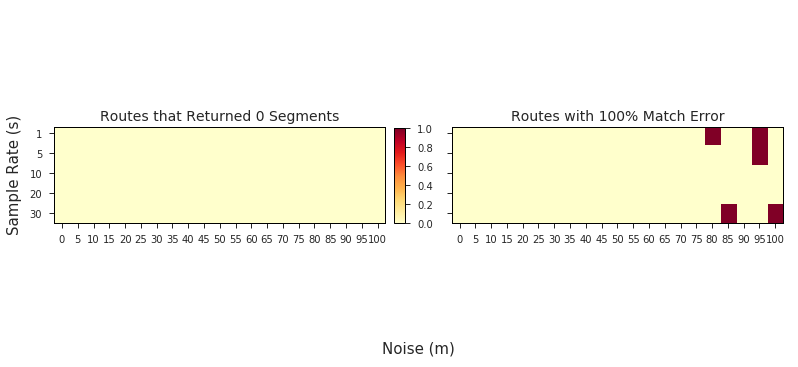

In [14]:
val.plot_pattern_failure(matchDf, sampleRates, noiseLevels)

## 4. Visualize the Scores

The graphs below represent the median scores for 6 error metrics applied to each of our 21,000 routes, broken down by sample rate and noise level. Plots in the left column are based solely on error rate, i.e the percentage of Type I, Type II, or Type I/II mismatches. The right-hand column shows the same metrics as the left, but weighted by segment length. The top right plot thus represents the metric used by Newton and Krumm, and the two plots below it represent the same value broken out by error type.

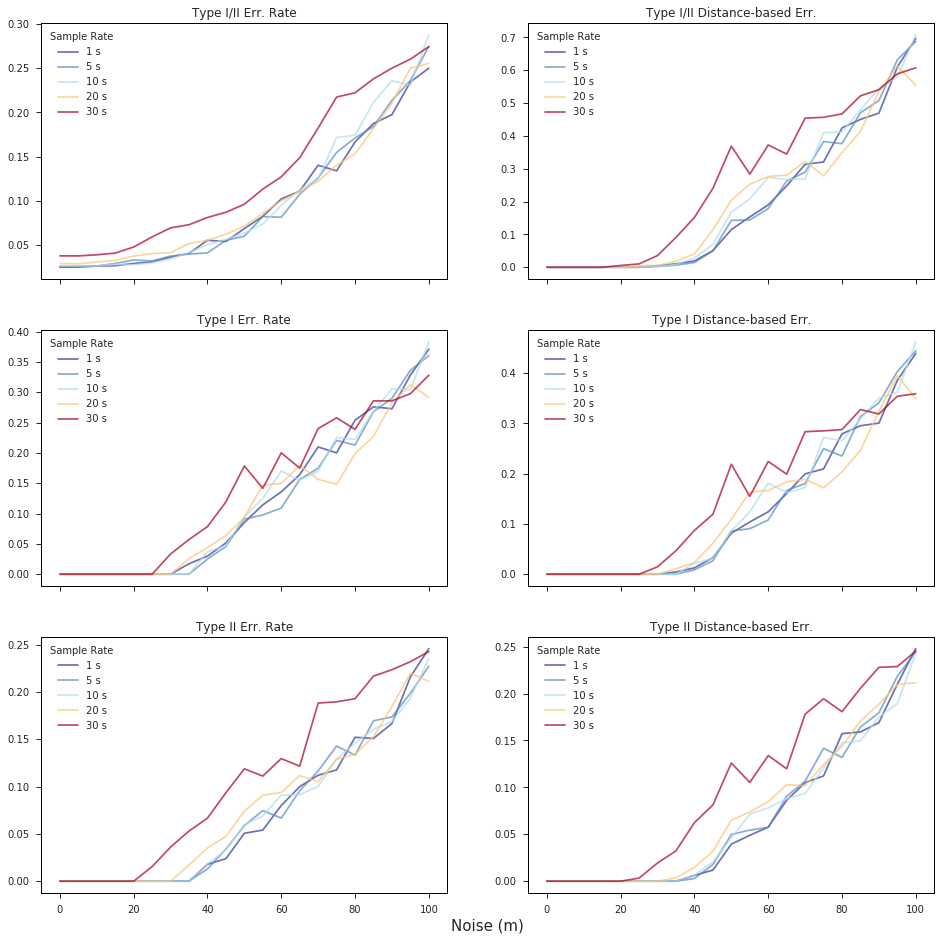

In [15]:
val.plot_distance_metrics(matchDf, sampleRates)

## 5. Results

There is a lot of valuable information to be gleaned from our validation process. The main takeaways are summarized below:
1. Below 50 m of noise, we obtain a median match accuracy of **90%** or better.
2. Clearly the positional accuracy of GPS data (vis-a-vis noise level) has a huge impact on rate of mismatch. However, there is little to no impact on error rates at noise levels below 20 m. 
3. Sample rate also has a significant effect on performance. What that effect is, however, depends significantly on the positional accuracy of the data. Higher frequency sample rates clearly perform better at lower levels of noise, but there exists a very consistent point of inflection (~80-90 m) about which the performance of low sample rate GPS traces (red) improves relative to that of the higher sample rates (blue). These results, consistent with the findings of Newton and Krumm (2009), suggest that lower sample rates tend to be more robust against mismatch error at higher levels of noise.
4. There does not appear to be a significant difference in the trends between the distance-based error metrics and those that do not consider segment length.
5. Similarly, the Type I, Type II, and Type I/II error rates very closely track one another, although the pattern of inflection described in (3) appears more pronounced in the Type II-based metrics.

Ultimately, our validation allows us to state with a greater measure of confidence that our map-matching is working as intended, at least in San Francisco:

<img src="last_image.png" alt="Drawing" style="width: 100%;"/>

<center><i>A perfect match on a route with 80 m of noise (5 s sample rate)</i></center>

In the next installment of this series, we will see how we can actually _use_ these error metrics to optimize the performance of our map-matching algorithm based on the quality of the data made available to us.